In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_community.document_loaders import WebBaseLoader
from langchain_groq import ChatGroq

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
## Load LLM model
model = 'qwen/qwen3-32b'
llm = ChatGroq(model=model)

In [13]:
with open('url.txt','r') as file:
    urls = file.read().splitlines()

print(urls)

['https://acera.ca/', 'https://acera.ca/about-us/', 'https://acera.ca/acera-insurance-real-estate-summit-2025/', 'https://acera.ca/am-i-covered-if-i-need-to-cancel-a-trip/', 'https://acera.ca/auto-insurance-renewal-request/', 'https://acera.ca/benefits/group-benefits-consulting/', 'https://acera.ca/blog/', 'https://acera.ca/business-insurance/', 'https://acera.ca/business/course-of-construction-insurance/', 'https://acera.ca/careers/', 'https://acera.ca/claims/', 'https://acera.ca/community/', 'https://acera.ca/compensation-disclosure/', 'https://acera.ca/contact/', 'https://acera.ca/cookies/', 'https://acera.ca/find-a-branch/', 'https://acera.ca/get-a-quote/', 'https://acera.ca/group-benefits/', 'https://acera.ca/insurance-glossary/', 'https://acera.ca/leadership/', 'https://acera.ca/myacera/', 'https://acera.ca/news/', 'https://acera.ca/our-brands/', 'https://acera.ca/our-brands/prizm-financial/', 'https://acera.ca/our-brands/rogers-insurance/', 'https://acera.ca/our-brands/rogers-mc

In [36]:
from bs4 import SoupStrainer

In [58]:
docs = [WebBaseLoader(web_path=url,bs_kwargs={'parse_only': SoupStrainer('main', class_='wp-block-group is-layout-flow wp-block-group-is-layout-flow')}).load() for url in urls]
docs

[[Document(metadata={'source': 'https://acera.ca/'}, page_content='\n\n\n\n\n\nPersonal Insurance\nWe know insurance by heart and our clients by name.\nNice to meet you! We’re Acera Insurance and we’re on a mission to make insurance more personable. Let our local experts show you how.\n\nGet a Quote\n\n\n\n\n\n\n\n\n\n\n\n\n\t\t\t\t\t\t\t\t\t\tThis video is decorative only with no sound.\n\t\t\t\t\t\t\t\t\t\tThe visuals do not provide additional information.\n\t\t\t\t\t\t\t\t\t\n\n\nBecertain.\n\n\n\n\n \n\n\n\n\n\n\n\t\t\t\t\t\t\t\t\t\tThis video is decorative only with no sound.\n\t\t\t\t\t\t\t\t\t\tThe visuals do not provide additional information.\n\t\t\t\t\t\t\t\t\t\n\n\n\n\nProudly Canadian and employee owned\n\n\n\n\n\n\n\n\nProtect your home, business or farm from severe weather.\nGet the knowledge and tools you need to be prepared and minimize your risks.\n\nRead Our Preparedness Guides\n\n\n\n\n\n\nStart with our most popular coverages.\nHow can we get you where you need to g

In [68]:
## cleaning data
import re
cleaned_docs = []
for i,doc in enumerate(docs):
    original_content = doc[0].page_content
    
    category_block_pattern = re.compile(
        r'(?:'               # Start a non-capturing group for repeated lines
        r'(?: {2,}|\t+)'     # Match 2 or more spaces OR one or more tabs (for indentation)
        r'[A-Za-z& ]+'       # Match the category text (letters, ampersands, spaces)
        r'\s*'               # Match any trailing whitespace on the line
        r'\n'                # Match the newline at the end of the category line
        r')+'                # Match one or more such category lines
        , re.IGNORECASE      # Make "All Categories" case-insensitive
    )
    # Use sub to replace the entire matched block with an empty string
    temp_content = re.sub(category_block_pattern, '', original_content, count=1)
    
    #temp_content = re.sub(r'\n+','\n',temp_content)
    
    # Step 2: Normalize Line Breaks (reduce 3+ newlines to two)
    # This preserves single and double newlines for paragraph breaks
    temp_content = re.sub(r'\n{3,}', '\n', temp_content)
    
    # Step 3: Normalize Spaces (reduce 2+ spaces/tabs to a single space)
    # This also handles other horizontal whitespace characters like tabs
    temp_content = re.sub(r'[ \t]{2,}', ' ', temp_content)
    
    # Step 4: Final strip of leading/trailing whitespace
    cleaned_content = temp_content.strip()
    
    doc[0].page_content = cleaned_content
    cleaned_docs.append(doc)

In [118]:
print(cleaned_docs[1][0].page_content)

About us
Be certain.
We’re in the business of giving you certainty. At Acera Insurance, all that we do revolves around giving our clients the best service experience and the utmost confidence in what we provide.
At a Glance
70+
Branches
1300+
Professionals
100+
Insurer Partners
Our Canadian roots run deep.
We’re built on the foundation of award-winning, independent insurance brokerages that have been serving communities across the country for over 60 years. By combining our strengths and stability, we’re bringing greater value, expertise and resources to individuals, families and businesses nationwide.As a Canadian company, our local perspectives enable us to better understand our clients’ needs and priorities. And, as a truly independent insurance brokerage, we provide professional, impartial advice and negotiate terms with the best interest of our valued clients in mind.
What’s in a name?
Being a proudly 100% Canadian-owned company inspired us to draw inspiration for our name from th

#### We have got cleaned data, now we will split the data into smaller chunks

In [76]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

doc_list = [item for sublist in cleaned_docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size = 500, chunk_overlap = 50)

doc_splits = text_splitter.split_documents(doc_list)

In [119]:
print(doc_splits[10].page_content)

Speak to your broker for more details on trip cancellation insurance. This coverage can be very valuable – especially when cancellations are so common due to the pandemic. However, not all scenarios are covered or may be more expensive to insure. That’s why speaking to a broker is a good place to start. They’ll find you the best coverage for your budget and help you understand your trip cancellation insurance.  
Tags: travel insurance, trip cancellation insurance, trip interruption insurance
←Previous: Faith & the Post-Pandemic World: Challenges Faced by Faith Organizations
Next: Where to Camp for Free in Alberta→


#### We have split our documents, now we will store it in vectore store and will create a retriever. We will be usign Chroma VS.

In [84]:
from langchain_openai import OpenAIEmbeddings
openai_embedding = OpenAIEmbeddings(model = 'text-embedding-3-large')

In [85]:
from langchain_community.vectorstores import Chroma

vectore_store = Chroma.from_documents(
    documents=doc_splits,
    collection_name='acera_rag',
    embedding=openai_embedding
)

retriever = vectore_store.as_retriever()

In [120]:
retriever.invoke('How many employees are in Acera')

[Document(metadata={'source': 'https://acera.ca/careers/'}, page_content='Careers at Acera Insurance\nChanging the way people feel about a career in insurance.\nChoose a career that empowers you to excel in and take ownership of your work, while having fun. Choose a career with Acera Insurance — we put people first!\n\nSee Current Opportunities\nBe a part of our growing team.\nAs an employer of choice, Acera Insurance offers an outstanding workplace and employee culture that creates valuable opportunities for all of our employees.\nChoosing a career with Acera Insurance means you’ll be:\n\nEncouraged to challenge the status quo and never stop learning in your commitment to excellence.\nEmpowered with a sense of accountability and autonomy to take ownership of your work.\nTreated with respect as we put our people first.\nRecognized for your achievements and engaged in festivities — big and small — that make work fun.'),
 Document(metadata={'source': 'https://acera.ca/careers/'}, page_co

#### Now we will create a retriever tool

In [121]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='acera_retriever',
    description='''
    Search and return information about Acera Insurance. Insurance coverages and services provided by Acera Insurance. You are a specialied agent.
    Use the 'retriever_tool' **only** when the query explicitly relates to Acera Insurance and Insurance Coverage. For all other queries, respond directly without using any tool. 
    For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    '''
)

In [122]:
retriever_tool.invoke('How many employees are in Acera')

'Careers at Acera Insurance\nChanging the way people feel about a career in insurance.\nChoose a career that empowers you to excel in and take ownership of your work, while having fun. Choose a career with Acera Insurance — we put people first!\n\nSee Current Opportunities\nBe a part of our growing team.\nAs an employer of choice, Acera Insurance offers an outstanding workplace and employee culture that creates valuable opportunities for all of our employees.\nChoosing a career with Acera Insurance means you’ll be:\n\nEncouraged to challenge the status quo and never stop learning in your commitment to excellence.\nEmpowered with a sense of accountability and autonomy to take ownership of your work.\nTreated with respect as we put our people first.\nRecognized for your achievements and engaged in festivities — big and small — that make work fun.\n\nIf this sounds good to you, come join our network of more than 1,300 professionals.\nAbout Acera Insurance\nAs the largest independent, empl

In [89]:
from langgraph.prebuilt import ToolNode, tools_condition

retriever_node = ToolNode([retriever_tool])

#### Bind LLM with Tool and will create LLM Decision function

In [90]:
llm_with_tool = llm.bind_tools([retriever_tool])

In [92]:
from typing import Annotated, Sequence, TypedDict, List
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage

class State(TypedDict):
    messages : Annotated[List[Sequence], add_messages]

In [97]:
def LLM_Decision_Function(state: State):
    print('<-- LLM Decision -->')
    
    message = state['messages']
    last_message = message[-1]
    print(last_message)
    question = last_message.content
    
    response = llm_with_tool.invoke(question)
    
    return {'messages': [response]}

In [123]:
message = [HumanMessage(content='How many employees are there in Acera')]
LLM_Decision_Function({'messages':message})

<-- LLM Decision -->
content='How many employees are there in Acera' additional_kwargs={} response_metadata={}


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6r572jjmj', 'function': {'arguments': '{"query":"number of employees"}', 'name': 'acera_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 122, 'prompt_tokens': 158, 'total_tokens': 280, 'completion_time': 0.211150902, 'prompt_time': 0.005922592, 'queue_time': 0.059838442, 'total_time': 0.217073494}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9233114a-af96-4065-9282-93e3fed490b3-0', tool_calls=[{'name': 'acera_retriever', 'args': {'query': 'number of employees'}, 'id': '6r572jjmj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 158, 'output_tokens': 122, 'total_tokens': 280})]}

#### We will now create a grader function which will decide if the retrieved chunk answers the user query correctly and will redirect to next step accordingly

In [100]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.prompts import PromptTemplate

class Grader(BaseModel):
    binary_result : str = Field(description="Relevance score 'yes' or 'no'")

In [109]:
from urllib import response


def grade_documents(state: State) -> Literal['generate_answer','rewrite_question']:
    print('<-- Grade Document -->')
    
    llm_with_structured_output = llm.with_structured_output(Grader)
    
    prompt = PromptTemplate(
        template='''You are a grader assessing relevance of a retrieved document to a user question.
            Here is the retrieved document: \n\n {context}
            Here is the user question: {question}
            If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        ''',
        input_variables=['context','question']
    )
    
    chain = prompt | llm_with_structured_output
    
    message = state['messages']
    question = message[0].content
    context = message[-1].content
    
    response = chain.invoke({'question':question,'context':context})
    
    score = response.binary_result
    
    if score =='yes':
        print(print("---Decision: Docs Are Relevant-------"))
        return 'generate_answer'
    else:
        print('---Decision: Docs Are Not Relevant------------')
        return 'rewrite_question'


In [110]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "How many employees are there in Acera?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        'id': 'npgbkf9js', 
                        'function': {
                            'arguments': '{"query":"number of employees"}', 
                            'name': 'acera_retriever'
                            }, 
                        'type': 'function'
                    }
                ]
            },

            {"role": "tool", "content": "If this sounds good to you, come join our network of more than 1,300 professionals.", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

<-- Grade Document -->
---Decision: Docs Are Relevant-------
None


'generate_answer'

#### We will write function to rewrite question in case the content provided by retriever is not relevant.

In [111]:
from click import prompt


def rewrite(state:State):
    ('<-- Rewrite User Query -->')
    
    message = state['messages']
    question = message[-1].content
    
    input = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
    ]
    
    response = llm.invoke(input)
    
    return {'messages':[response]}

#### Now we will build Generate Answer node. If we pass the grader check, we can generate the final answer based on the original question and the retrieved context.

In [138]:
from langchain import hub

def generate_answer(state: State):
    print('<-- Generate Output -->')
    
    message = state['messages']
    question = message[0].content
    context = message[-1].content
    
    prompt = PromptTemplate(
        template= '''"You are an Insurance assistant working for Acera Insurance for question-answering tasks. "
            "Use the following pieces of retrieved context to answer the question. "
            "Also provide information about coverages which Acera Insurance can provide related to user query"
            "If you don't know the answer, just say that you don't know. "
            "Use three sentences maximum and keep the answer concise.\n"
            "Question: {question} \n"
            "Context: {context}"
        '''
    )
    
    rag_llm = prompt | llm
    response = rag_llm.invoke({'question':question, 'context':context})
    
    return {'messages':[response]}

### Now we will create the graph

In [139]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node('LLM Supervisor', LLM_Decision_Function)
builder.add_node('Vector Retriever', retriever_node)
builder.add_node('Query Rewriter', rewrite)
builder.add_node('Output Generator', generate_answer)

## Logic
builder.add_edge(START,'LLM Supervisor')
builder.add_conditional_edges(
    'LLM Supervisor',
    tools_condition,
    {
        'tools': 'Vector Retriever',
        END:END
    }
)
builder.add_conditional_edges(
    'Vector Retriever',
    grade_documents,
    {
        'generate_answer':'Output Generator',
        'rewrite_question':'Query Rewriter'
    }
)
builder.add_edge('Query Rewriter','LLM Supervisor')
builder.add_edge('Output Generator', END)

app = builder.compile()

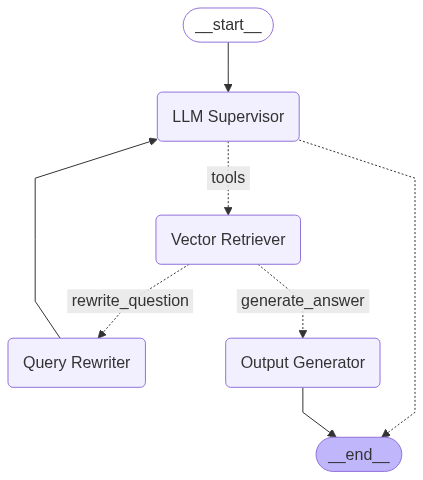

In [140]:
app

In [141]:
message = [HumanMessage(content='I live in a 2 bedroom apartment, need tenant insurance?')]
res = app.invoke({'messages':message})
res

<-- LLM Decision -->
content='I live in a 2 bedroom apartment, need tenant insurance?' additional_kwargs={} response_metadata={} id='cd489ea1-0755-444e-b9d6-6dddcb2e1d2a'
<-- Grade Document -->
---Decision: Docs Are Relevant-------
None
<-- Generate Output -->


{'messages': [HumanMessage(content='I live in a 2 bedroom apartment, need tenant insurance?', additional_kwargs={}, response_metadata={}, id='cd489ea1-0755-444e-b9d6-6dddcb2e1d2a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'x3ygpd6zw', 'function': {'arguments': '{"query":"tenant insurance coverage for 2 bedroom apartment"}', 'name': 'acera_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 317, 'prompt_tokens': 163, 'total_tokens': 480, 'completion_time': 0.833564786, 'prompt_time': 0.010491111, 'queue_time': 0.061840253, 'total_time': 0.844055897}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_7a0b0d2d9a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--933ae8b0-e51b-4bd5-9a1c-469dc022553a-0', tool_calls=[{'name': 'acera_retriever', 'args': {'query': 'tenant insurance coverage for 2 bedroom apartment'}, 'id': 'x3ygpd6zw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 163, 'output_tokens': 

In [142]:
import pprint
for r in res['messages']:
    r.pretty_print()

================================ Human Message =================================

I live in a 2 bedroom apartment, need tenant insurance?
================================== Ai Message ==================================
Tool Calls:
  acera_retriever (x3ygpd6zw)
 Call ID: x3ygpd6zw
  Args:
    query: tenant insurance coverage for 2 bedroom apartment
================================= Tool Message =================================
Name: acera_retriever

Helpful tips from our advisors.
Keep your space and belongings protected. Our advisors are here to help you find the right coverage for you.
“Your landlord’s insurance will not cover your personal property you brought into the home nor would it cover those additional expenses should you be faced with being forced out of your home due to a mass evacuation or loss. Your comprehensive tenant insurance policy is personal to protecting you.”
 – Carol Moeller, Client Advisor | Kelowna, BC“Tenant insurance protects more than just your personal bel